In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
    }
plt.rcParams.update(tex_fonts)

# Preprocess data

In [149]:
# read in data
df = pd.read_csv('../air_weather_data/pollution_and_weather_cleaned.csv')
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d %H:%M') # change time column to pandas datetime
df = df.set_index('Date') # date column as index

In [150]:
# create separate dataframes

# df_PM10 = df['PM$_{10}$, Torkel Knutssonsgatan'].to_frame()
# df_PM2p5 = df['PM$_{2.5}$, Torkel Knutssonsgatan'].to_frame()

df_PM10 = df[['PM$_{10}$, Torkel Knutssonsgatan', 'PM$_{10}$, Hornsgatan', 'PM$_{10}$, Norr Malma']]
df_PM2p5 = df[['PM$_{2.5}$, Torkel Knutssonsgatan', 'PM$_{2.5}$, Hornsgatan', 'PM$_{2.5}$, Norr Malma']]

In [151]:
# drop negative and zero values and interpolate
df_PM10[df_PM10 <= 0] = np.NaN
df_PM10.interpolate(inplace=True)

df_PM2p5[df_PM2p5 <= 0] = np.NaN
df_PM2p5.interpolate(inplace=True)

/var/folders/3k/1wztchzs50j4jyq74xpccr3m0000gn/T/ipykernel_6707/4134975453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PM10[df_PM10 <= 0] = np.NaN
/var/folders/3k/1wztchzs50j4jyq74xpccr3m0000gn/T/ipykernel_6707/4134975453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PM10[df_PM10 <= 0] = np.NaN
/var/folders/3k/1wztchzs50j4jyq74xpccr3m0000gn/T/ipykernel_6707/4134975453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [152]:
# create lagged values

# PM10
df_PM10['PM$_{10}$, Torkel Knutssonsgatan lag1'] = df_PM10['PM$_{10}$, Torkel Knutssonsgatan'].shift(1)
df_PM10['PM$_{10}$, Torkel Knutssonsgatan lag2'] = df_PM10['PM$_{10}$, Torkel Knutssonsgatan'].shift(2)
df_PM10['PM$_{10}$, Hornsgatan lag1'] = df_PM10['PM$_{10}$, Hornsgatan'].shift(1)
df_PM10['PM$_{10}$, Norr Malma lag1'] = df_PM10['PM$_{10}$, Norr Malma'].shift(1)


df_PM10.dropna(inplace=True)

# PM2.5
df_PM2p5['PM$_{2.5}$, Torkel Knutssonsgatan lag1'] = df_PM2p5['PM$_{2.5}$, Torkel Knutssonsgatan'].shift(1)
df_PM2p5['PM$_{2.5}$, Torkel Knutssonsgatan lag2'] = df_PM2p5['PM$_{2.5}$, Torkel Knutssonsgatan'].shift(2)
df_PM2p5['PM$_{2.5}$, Hornsgatan, lag1'] = df_PM2p5['PM$_{2.5}$, Hornsgatan'].shift(1)
df_PM2p5['PM$_{2.5}$, Norr Malma, lag1'] = df_PM2p5['PM$_{2.5}$, Norr Malma'].shift(1)

df_PM2p5.dropna(inplace=True)

/var/folders/3k/1wztchzs50j4jyq74xpccr3m0000gn/T/ipykernel_6707/3270959391.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PM10['PM$_{10}$, Torkel Knutssonsgatan lag1'] = df_PM10['PM$_{10}$, Torkel Knutssonsgatan'].shift(1)
/var/folders/3k/1wztchzs50j4jyq74xpccr3m0000gn/T/ipykernel_6707/3270959391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PM10['PM$_{10}$, Torkel Knutssonsgatan lag2'] = df_PM10['PM$_{10}$, Torkel Knutssonsgatan'].shift(2)
/var/folders/3k/1wztchzs50j4jyq74xpccr3m0000gn/T/i

In [153]:
# split into train an test sets
df_PM10_train = df_PM10.loc['2016-01-01':'2019-01-01']
df_PM10_test = df_PM10['2020-09-01 00:00:00':]

df_PM2p5_train = df_PM2p5.loc['2016-01-01':'2019-01-01']
df_PM2p5_test = df_PM2p5['2020-09-01 00:00:00':]

In [154]:
# log transform training data
df_PM10_train = np.log(df_PM10_train)
df_PM2p5_train = np.log(df_PM2p5_train)

In [155]:
# Create X and y frames

X_PM10 = df_PM10_train.iloc[:,1:]
X_PM10.insert(0, 'intercept', 1)
y_PM10 = df_PM10_train['PM$_{10}$, Torkel Knutssonsgatan']

X_PM2p5 = df_PM2p5_train.iloc[:,1:]
X_PM2p5.insert(0, 'intercept', 1)
y_PM2p5 = df_PM2p5_train['PM$_{2.5}$, Torkel Knutssonsgatan']

In [156]:
X_PM10.drop('PM$_{10}$, Hornsgatan', axis=1, inplace=True)
X_PM2p5.drop('PM$_{2.5}$, Hornsgatan', axis=1, inplace=True)

X_PM10.drop('PM$_{10}$, Norr Malma', axis=1, inplace=True)
X_PM2p5.drop('PM$_{2.5}$, Norr Malma', axis=1, inplace=True)

/var/folders/3k/1wztchzs50j4jyq74xpccr3m0000gn/T/ipykernel_6707/3040727585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_PM10.drop('PM$_{10}$, Hornsgatan', axis=1, inplace=True)
/var/folders/3k/1wztchzs50j4jyq74xpccr3m0000gn/T/ipykernel_6707/3040727585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_PM2p5.drop('PM$_{2.5}$, Hornsgatan', axis=1, inplace=True)
/var/folders/3k/1wztchzs50j4jyq74xpccr3m0000gn/T/ipykernel_6707/3040727585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

# Fit OLS models

In [157]:
# PM10
lmod_PM10 = sm.OLS(y_PM10, X_PM10).fit()
print(lmod_PM10.summary())#.as_latex())

                                   OLS Regression Results                                   
Dep. Variable:     PM$_{10}$, Torkel Knutssonsgatan   R-squared:                       0.755
Model:                                          OLS   Adj. R-squared:                  0.755
Method:                               Least Squares   F-statistic:                 2.026e+04
Date:                              Thu, 11 Aug 2022   Prob (F-statistic):               0.00
Time:                                      23:53:24   Log-Likelihood:                -10505.
No. Observations:                             26328   AIC:                         2.102e+04
Df Residuals:                                 26323   BIC:                         2.106e+04
Df Model:                                         4                                         
Covariance Type:                          nonrobust                                         
                                            coef    std err          t

In [158]:
# PM2.5
lmod_PM2p5 = sm.OLS(y_PM2p5,X_PM2p5).fit()
print(lmod_PM2p5.summary())#.as_latex())
# for table in lmod_PM2p5.summary().tables:
#     print(table.as_latex_tabular())

                                    OLS Regression Results                                   
Dep. Variable:     PM$_{2.5}$, Torkel Knutssonsgatan   R-squared:                       0.927
Model:                                           OLS   Adj. R-squared:                  0.927
Method:                                Least Squares   F-statistic:                 8.370e+04
Date:                               Thu, 11 Aug 2022   Prob (F-statistic):               0.00
Time:                                       23:53:24   Log-Likelihood:                 4594.4
No. Observations:                              26328   AIC:                            -9179.
Df Residuals:                                  26323   BIC:                            -9138.
Df Model:                                          4                                         
Covariance Type:                           nonrobust                                         
                                             coef    std err

# Make predictions on new data

In [159]:
# PM10
y_test_PM10 = df_PM10_test['PM$_{10}$, Torkel Knutssonsgatan'] # keep the target y in original scale
df_PM10_test = np.log(df_PM10_test) # log transform
df_PM10_test = df_PM10_test.drop('PM$_{10}$, Torkel Knutssonsgatan', axis=1) 
df_PM10_test = df_PM10_test.drop('PM$_{10}$, Hornsgatan', axis=1) 
df_PM10_test = df_PM10_test.drop('PM$_{10}$, Norr Malma', axis=1) 


# PM2.5
y_test_PM2p5 = df_PM2p5_test['PM$_{2.5}$, Torkel Knutssonsgatan'] # keep the target y in original scale
df_PM2p5_test = np.log(df_PM2p5_test) # log transform
df_PM2p5_test = df_PM2p5_test.drop('PM$_{2.5}$, Torkel Knutssonsgatan', axis=1) 
df_PM2p5_test = df_PM2p5_test.drop('PM$_{2.5}$, Hornsgatan', axis=1) 
df_PM2p5_test = df_PM2p5_test.drop('PM$_{2.5}$, Norr Malma', axis=1) 

In [160]:
df_PM10_test.insert(0, 'intercept', 1)
df_PM2p5_test.insert(0, 'intercept', 1)

In [161]:
df_get_predictions_PM10 = np.exp(lmod_PM10.get_prediction(df_PM10_test).summary_frame())
df_get_predictions_PM10.rename(columns={'mean':'PM$_{10}$, predictions'}, inplace=True)
df_get_predictions_PM10;

In [162]:
np.sqrt(mean_squared_error(df_get_predictions_PM10['PM$_{10}$, predictions'], y_test_PM10)).round(3)

3.793

In [163]:
df_get_predictions_PM2p5 = np.exp(lmod_PM2p5.get_prediction(df_PM2p5_test).summary_frame())
df_get_predictions_PM2p5.rename(columns={'mean':'PM$_{2.5}$, predictions'}, inplace=True)
df_get_predictions_PM2p5;

In [164]:
np.sqrt(mean_squared_error(df_get_predictions_PM2p5['PM$_{2.5}$, predictions'], y_test_PM2p5)).round(3)

1.242

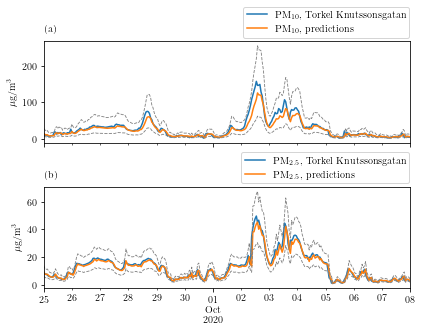

In [165]:
fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout=True, figsize=(5.75, 4.5), sharex=True)
# fig, (ax1, ax2) = plt.subplots(1,2, constrained_layout=True, figsize=(10, 3), sharex=True)

date1 = '2020-09-25'
date2 = '2020-10-08 00:00:00'

# PM10
y_test_PM10[date1:date2].plot(ax=ax1) # PM10 values
df_get_predictions_PM10[date1:date2]['PM$_{10}$, predictions'].plot(ax=ax1) # PM10 predicted
df_get_predictions_PM10[date1:date2]['obs_ci_lower'].plot(
                        linestyle='dashed', linewidth=.85, color='gray', label='_nolegend_', ax=ax1)
df_get_predictions_PM10[date1:date2]['obs_ci_upper'].plot(
                        linestyle='dashed', linewidth=.85, color='gray', label='_nolegend_', ax=ax1)
ax1.legend(loc='lower right', bbox_to_anchor= (1.0, 1.025), ncol=1, borderaxespad=0.1)
ax1.annotate('(a)', xy=(0.0, 1.09), xycoords="axes fraction")
ax1.set_ylabel('$\mu$g/m$^3$')

# PM2.5
y_test_PM2p5[date1:date2].plot(ax=ax2) # PM2.5 values
df_get_predictions_PM2p5[date1:date2]['PM$_{2.5}$, predictions'].plot(ax=ax2) # PM2.5 predicted
df_get_predictions_PM2p5[date1:date2]['obs_ci_lower'].plot(
                        linestyle='dashed', linewidth=.85, color='gray', label='_nolegend_', ax=ax2)
df_get_predictions_PM2p5[date1:date2]['obs_ci_upper'].plot(
                        linestyle='dashed', linewidth=.85, color='gray', label='_nolegend_', ax=ax2)
ax2.legend(loc='lower right', bbox_to_anchor= (1.0, 1.025), ncol=1, borderaxespad=0.1)
ax2.annotate('(b)', xy=(0.0, 1.09), xycoords="axes fraction")
ax2.set_ylabel('$\mu$g/m$^3$')

plt.xlabel('')
plt.savefig('../plots/MLR_PM10.pdf')

# Some model diagnostics

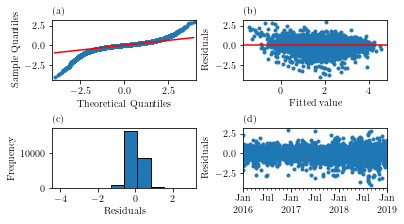

In [166]:
# PM10
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True, figsize = (5.5, 3))

# QQ-plot of studentized residuals
sm.qqplot(lmod_PM10.resid, line='q', ax=ax1, marker=".")
ax1.annotate('(a)', xy=(0, 1.09), xycoords="axes fraction")

# fitted vs residuals
ax2.scatter(lmod_PM10.fittedvalues, lmod_PM10.resid, marker=".")#, facecolors='none', edgecolors='#1f77b4')
ax2.axhline(0, color='r')
ax2.set_xlabel('Fitted value')
ax2.set_ylabel('Residuals')
ax2.annotate('(b)', xy=(0, 1.09), xycoords="axes fraction")


ax3.hist(lmod_PM10.resid, edgecolor='black')
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
ax3.annotate('(c)', xy=(0, 1.09), xycoords="axes fraction")

lmod_PM10.resid.plot(linestyle="", marker='.', ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('Residuals')
ax4.annotate('(d)', xy=(0, 1.09), xycoords="axes fraction")

plt.savefig('../plots/Residual_plots_MLR_PM10.pdf')

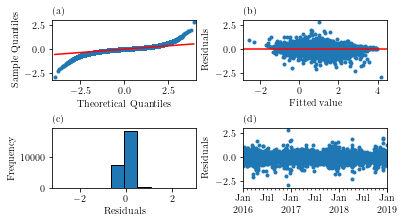

In [167]:
# PM10
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True, figsize = (5.5, 3))

# QQ-plot of studentized residuals
sm.qqplot(lmod_PM2p5.resid, line='q', ax=ax1, marker=".")
ax1.annotate('(a)', xy=(0, 1.09), xycoords="axes fraction")

# fitted vs residuals
ax2.scatter(lmod_PM2p5.fittedvalues, lmod_PM2p5.resid, marker=".")#, facecolors='none', edgecolors='#1f77b4')
ax2.axhline(0, color='r')
ax2.set_xlabel('Fitted value')
ax2.set_ylabel('Residuals')
ax2.annotate('(b)', xy=(0, 1.09), xycoords="axes fraction")


ax3.hist(lmod_PM2p5.resid, edgecolor='black')
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
ax3.annotate('(c)', xy=(0, 1.09), xycoords="axes fraction")

lmod_PM2p5.resid.plot(linestyle="", marker='.', ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('Residuals')
ax4.annotate('(d)', xy=(0, 1.09), xycoords="axes fraction")

plt.savefig('../plots/Residual_plots_MLR_PM2.5.pdf')

# Ridge test #

In [168]:
X_PM10.drop('intercept', axis=1, inplace=True)

/var/folders/3k/1wztchzs50j4jyq74xpccr3m0000gn/T/ipykernel_6707/4124268584.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_PM10.drop('intercept', axis=1, inplace=True)


In [169]:
# from sklearn.preprocessing import MinMaxScaler
def normalize(data):
  """"
  Input: NumPy ndarray
  Output: NumPy ndarray with column min == 0 and max == 1
  """
  return (data - np.min(data,axis=0))/(np.max(data,axis=0) - np.min(data,axis=0))

In [170]:
from sklearn import linear_model

n_alphas = 100
alphas = np.logspace(-2, 6, n_alphas)
coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X_PM10, y_PM10)
    coefs.append(ridge.coef_)

10.0


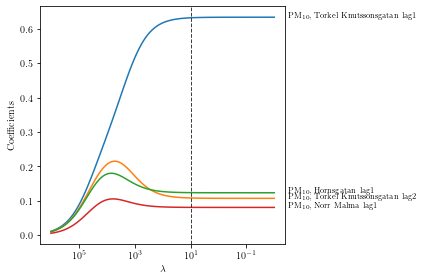

In [171]:
# select value of lambda with cross-validation
from sklearn.model_selection import GridSearchCV
pars = {'alpha':np.logspace(-1, 1, n_alphas)}
rr = GridSearchCV(linear_model.Ridge(), pars, scoring='r2', cv=10)
rr.fit(X_PM10, y_PM10)

bestalpha = rr.best_params_['alpha']
print(bestalpha)

# ridge trace plot
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
# ax.set_ylim(-.2,.55)

for i in range(len(X_PM10.columns)):
    plt.text(min(alphas)/3, coefs[0][i], X_PM10.columns[i], fontsize=8)

plt.xlabel(r'$\lambda$')
plt.ylabel('Coefficients')
plt.axvline(bestalpha, color='k', linestyle='--', linewidth=1, alpha=.75)
plt.tight_layout()
# # plt.savefig('../plots/PM10_ridge_regression.pdf')

In [172]:
rrbest = linear_model.Ridge(alpha=bestalpha, fit_intercept=True)
rrbest.fit(X_PM10, y_PM10)
(np.sqrt(mean_squared_error(rrbest.predict(X_PM10), y_PM10)).round(5), 
np.sqrt(mean_squared_error(rrbest.predict(), y_test)).round(5)
)

TypeError: LinearModel.predict() missing 1 required positional argument: 'X'